In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

In [2]:
# Load the data
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

# Other data
#train_df_fault = pd.read_csv('TEP_Faulty_Training.csv')
#train_df_free = pd.read_csv('TEP_FaultFree_Training.csv')
#test_df_fault = pd.read_csv('TEP_Faulty_Testing.csv')
#test_df_free = pd.read_csv('TEP_FaultFree_Testing.csv')

# Concatenate the training datasets vertically
#train_df = pd.concat([train_df_free, train_df_fault], ignore_index=True)

# Concatenate the testing datasets vertically
#test_df = pd.concat([test_df_free, test_df_fault], ignore_index=True)

# Display the shapes of the combined datasets
print("Shape of combined training dataset:", train_df.shape)
print("Shape of combined testing dataset:", test_df.shape)

# Display the first few rows of the dataset
train_df['faultNumber'].unique()

Shape of combined training dataset: (260000, 56)
Shape of combined testing dataset: (98000, 56)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [ ]:
# Function to engineer features
def engineer_features(df):
    '''
    # Extract time-related features from timestamp column if available
    if 'sample' in df.columns:
        df['hour'] = df['sample'].dt.hour
        df['day_of_week'] = df['sample'].dt.dayofweek
        df['month'] = df['sample'].dt.month
        # Add more time-related features as needed
    '''
    
    # Rolling statistics
    window_size = 10
    df['xmeas_1_roll_mean'] = df['xmeas_1'].rolling(window=window_size).mean()
    df['xmeas_1_roll_std'] = df['xmeas_1'].rolling(window=window_size).std()
    # Add rolling statistics for other features
    
    '''
    # Lagged features
    lag_periods = [1, 2, 3]
    for lag in lag_periods:
        df[f'xmeas_1_lag_{lag}'] = df['xmeas_1'].shift(lag)
        # Add lagged features for other features
    '''
    # Seasonality and Trend Decomposition (using seasonal_decompose from statsmodels)
    decomposition = seasonal_decompose(df['xmeas_1'], model='additive', period=24)  # Assuming hourly data
    df['xmeas_1_trend'] = decomposition.trend
    df['xmeas_1_seasonal'] = decomposition.seasonal
    df['xmeas_1_residual'] = decomposition.resid
    
    # Interaction features (example)
    df['xmeas_1_xmeas_2_product'] = df['xmeas_1'] * df['xmeas_2']
    
    # Feature scaling and normalization (example using Min-Max scaling)
    
    scaler = MinMaxScaler()
    df[['xmeas_1', 'xmeas_2']] = scaler.fit_transform(df[['xmeas_1', 'xmeas_2']])
    
    # Additional domain-specific features or transformations as needed
    
    return df

# Apply feature engineering to the training and testing datasets
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)


In [21]:
# Define the number of samples per simulationRun for training and testing datasets
train_samples_per_run = 500
test_samples_per_run = 250 

# Subsample the training data by choosing a fixed number of random samples per simulationRun
train_df_subsampled = train_df.groupby('simulationRun', group_keys=False).apply(lambda x: x.sample(min(len(x), train_samples_per_run), random_state=42))

# Subsample the testing data by choosing a fixed number of random samples per simulationRun
test_df_subsampled = test_df.groupby('simulationRun', group_keys=False).apply(lambda x: x.sample(min(len(x), test_samples_per_run), random_state=42))

# Display the shapes of the subsampled datasets
print("Shape of subsampled training dataset:", train_df_subsampled.shape)
print("Shape of subsampled testing dataset:", test_df_subsampled.shape)

Shape of subsampled training dataset: (20000, 56)
Shape of subsampled testing dataset: (2500, 56)


In [22]:
#train_df_c = train_df_subsampled
#test_df_c = test_df_subsampled

train_df_c = train_df
test_df_c = test_df

# Remove unnecessary columns 2
train_df_c = train_df_c.drop(columns=['simulationRun', 'sample'])
test_df_c = test_df_c.drop(columns=['simulationRun', 'sample'])

In [23]:
# Remove fault numbers 3, 5, 9, 15, and 16
#faults_to_remove = [3, 5, 9, 15, 16]
faults_to_remove = []
train_df_c = train_df_c[~train_df_c['faultNumber'].isin(faults_to_remove)]
test_df_c = test_df_c[~test_df_c['faultNumber'].isin(faults_to_remove)]

# Split features and target for both training and test datasets
X_train = train_df_c.drop(columns=['faultNumber'])
y_train = train_df_c['faultNumber']
X_test = test_df_c.drop(columns=['faultNumber'])
y_test = test_df_c['faultNumber']

# Remove columns xmeas_23 to xmeas_41
#cols_to_remove = [f'xmeas_{i}' for i in range(23, 42)]
cols_to_remove = []
X_train_processed = X_train.drop(columns=cols_to_remove)
X_test_processed = X_test.drop(columns=cols_to_remove)

# Convert faultNumber to categorical for the training and test datasets
num_classes = len(train_df_c['faultNumber'].unique())
y_train_cat = pd.get_dummies(y_train)
y_test_cat = pd.get_dummies(y_test)

# Standardize the processed data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Display the number of classes
print("Number of classes:", num_classes)

Number of classes: 21


In [24]:
# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this as needed

# Initialize lists to store evaluation metrics for each fold
all_fold_metrics = []

# Initialize lists to store training history across all folds
all_train_losses = []
all_val_losses = []

# Define your model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

# Perform cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train), 1):
    print(f"Training on fold {fold}...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_cat.iloc[train_index], y_train_cat.iloc[val_index]
    
    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping], verbose=1)
    
    # Store training history for this fold
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    
    # Evaluate the model on the validation set
    val_loss, val_precision = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Precision: {val_precision:.4f}")
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate evaluation metrics (e.g., confusion matrix, classification report)
    cm = confusion_matrix(np.argmax(y_val_fold.values, axis=1), y_pred_classes)
    cr = classification_report(np.argmax(y_val_fold.values, axis=1), y_pred_classes)
    
    # Store evaluation metrics for this fold
    fold_metrics = {
        'Confusion Matrix': cm,
        'Classification Report': cr,
        'Validation Loss': val_loss,
        'Validation Precision': val_precision
    }
    all_fold_metrics.append(fold_metrics)


Training on fold 1...
Epoch 1/50
6500/6500 [==============================] - 8s 1ms/step - loss: 1.5165 - precision_3: 0.8569 - val_loss: 0.9156 - val_precision_3: 0.9304
Epoch 2/50
6500/6500 [==============================] - 7s 1ms/step - loss: 1.0898 - precision_3: 0.8776 - val_loss: 0.8353 - val_precision_3: 0.9327
Epoch 3/50
6500/6500 [==============================] - 7s 1ms/step - loss: 1.0046 - precision_3: 0.8836 - val_loss: 0.7493 - val_precision_3: 0.9336
Epoch 4/50
6500/6500 [==============================] - 7s 1ms/step - loss: 0.9499 - precision_3: 0.8816 - val_loss: 0.7179 - val_precision_3: 0.9325
Epoch 5/50
6500/6500 [==============================] - 7s 1ms/step - loss: 0.9233 - precision_3: 0.8817 - val_loss: 0.7051 - val_precision_3: 0.9307
Epoch 6/50
6500/6500 [==============================] - 7s 1ms/step - loss: 0.9047 - precision_3: 0.8836 - val_loss: 0.6888 - val_precision_3: 0.9330
Epoch 7/50
6500/6500 [==============================] - 7s 1ms/step - loss: 0.

In [25]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test_cat)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3063/3063 [==============================] - 2s 634us/step - loss: 0.6031 - precision_3: 0.9389
Test Loss: 0.6031438112258911
Test Accuracy: 0.9388567209243774


3063/3063 [==============================] - 2s 522us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.40      1.00      0.57      2000
           1       1.00      0.98      0.99      4800
           2       1.00      0.97      0.98      4800
           3       0.27      0.09      0.14      4800
           4       0.87      0.99      0.93      4800
           5       0.99      0.95      0.97      4800
           6       1.00      1.00      1.00      4800
           7       1.00      1.00      1.00      4800
           8       0.95      0.92      0.93      4800
           9       0.28      0.08      0.12      4800
          10       0.90      0.83      0.86      4800
          11       0.91      0.69      0.79      4800
          12       0.94      0.92      0.93      4800
          13       0.99      0.87      0.93      4800
          14       1.00      0.95      0.97      4800
          15       0.25      0.76      0.38      480

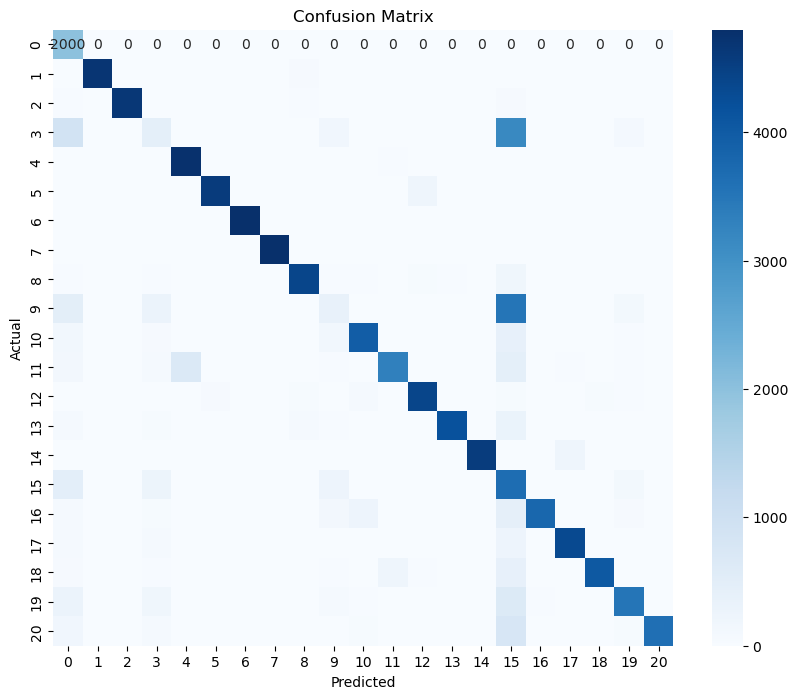

In [26]:
# Predictions on test data
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_true = np.argmax(y_test_cat.values, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_pred_classes)

# Calculate precision, recall, and F1 score
class_report = classification_report(y_test_true, y_pred_classes)
print("Classification Report:\n", class_report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test_true), yticklabels=np.unique(y_test_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()